In [1]:
import sys
sys.path.append('..')
from dataloader.datamodule_ecog2ph import ECoGPhonemeDataModule
import numpy as np
import torch
from utils.utils import load_model
from model.unit_rnnt import SpeechModel
from model.rnnt_beamsearch import RNNTBeamSearch
import time
import tqdm
import torchaudio
import matplotlib.pyplot as plt

/home/cheoljun/anaconda3/envs/transformer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda'

In [192]:
model,cfg = load_model('../outputs/2023-10-05/05-09-40/phoneme-wspace-tm1k-causal-v2',
                       MODEL=SpeechModel, mode='best')

In [193]:
model = model.net.eval()

In [194]:
model = model.to('cuda')

In [195]:
decoder = RNNTBeamSearch(model.rnnt,model.blank_id,step_max_tokens=100)

In [150]:
datamodule = ECoGPhonemeDataModule(**cfg['data'])

In [151]:
test_loader = datamodule.test_dataloader()

In [175]:
test_loader.dataset.transform=None

In [203]:

stats={}
best_n = 1
for chunk_size in [4,8,12,16]:
    test_times=[]
    preds =[]
    gts =[]
    for i in tqdm.tqdm(range(len(test_loader.dataset))):
        x = test_loader.dataset.__getitem__(i)
        input_all = x['ecog'].to(device)
        len_all = torch.tensor(x['ecog_len']).to(device)

        state, hypothesis = None, None
        times=[]
        for i in range(0,x['ecog_len'],chunk_size):
            start_time = time.time()
            input_ = input_all[i:i+chunk_size]
            if len(input_)<chunk_size:
                break
            len_ = torch.tensor(len(input_),device=device)
            hypos, state = decoder.infer(input_, len_, 20, state=state, hypothesis=hypothesis)
            hypothesis = hypos[:best_n]
            end_time = time.time()
            #phs = model.token_decoder(hypos[0][0][1:])
            #print(phs)
            times.append(end_time-start_time)
        preds.append(model.token_decoder(hypos[0][0][1:]))
        gts.append(model.tokenizer([x['text']])[-1][0])
        times = np.array(times)
        test_times.append(times)
    chunk_time = 6/200*chunk_size
    mean_times = np.array([(test_times[i][:128//chunk_size]).mean() for i in range(len(test_times))])#+chunk_time
    pers = np.array([torchaudio.functional.edit_distance(pred_.split(' '), gt_.split(' ')) / len(gt_.split(' ')) 
            for pred_,gt_ in zip(preds, gts)])
    stats[(chunk_size, best_n)] ={'mean_time':mean_times,
                                  'chunk_time':chunk_time,
                                  'per':pers}

100%|██████████████████████████████████████████████████████████████████| 250/250 [02:43<00:00,  1.53it/s]


/tmp/ipykernel_1030569/2002342706.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(names)#, rotation = 30, ha='right', rotation_mode='anchor')
/tmp/ipykernel_1030569/2002342706.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(names)#, rotation = 30, ha='right', rotation_mode='anchor')
/tmp/ipykernel_1030569/2002342706.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(names)#, rotation = 30, ha='right', rotation_mode='anchor')


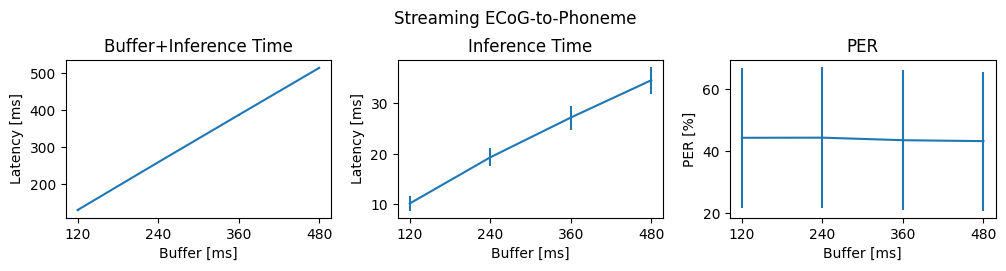

In [204]:

names=[]
time_means=[]
time_stds=[]
per_means=[]
per_stds=[]
buffer_times=[]
for (chunk_size, best_n), results in stats.items():
    chunk_time = 6/200*chunk_size
    buffer_times.append(chunk_time)
    name = f'{int(chunk_time*1000)}'
    names.append(name)
    time_means.append((results['mean_time']*1000).mean())
    time_stds.append((results['mean_time']*1000).std())
    per_means.append((results['per']*100).mean())
    per_stds.append((results['per']*100).std())
time_means = np.array(time_means)
time_stds=np.array(time_stds)
per_means=np.array(per_means)
per_stds=np.array(per_stds)
buffer_times=np.array(buffer_times)

fig, axs = plt.subplots(1, 3, figsize=(12,2))
axs[0].errorbar(names, time_means+buffer_times*1000, yerr=time_stds, label='latency[ms]')
axs[0].set_ylabel('Latency [ms]')
axs[0].set_title('Buffer+Inference Time')
axs[0].set_xlabel('Buffer [ms]')
axs[0].set_xticklabels(names)#, rotation = 30, ha='right', rotation_mode='anchor')
axs[1].errorbar(names, time_means, yerr=time_stds, label='latency[ms]')
axs[1].set_ylabel('Latency [ms]')
axs[1].set_title('Inference Time')
axs[1].set_xlabel('Buffer [ms]')
axs[1].set_xticklabels(names)#, rotation = 30, ha='right', rotation_mode='anchor')
axs[2].errorbar(names, per_means, yerr=per_stds, label='latency[ms]')
axs[2].set_ylabel('PER [%]')
axs[2].set_xlabel('Buffer [ms]')
axs[2].set_title('PER')
axs[2].set_xticklabels(names)#, rotation = 30, ha='right', rotation_mode='anchor')
title = fig.suptitle('Streaming ECoG-to-Phoneme')

# Increase the space around the super title
title.set_y(1.15)  
plt.subplots_adjust(top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)

In [202]:
chunk_size=4
best_n=1
i=6
x = test_loader.dataset.__getitem__(i)
input_all = x['ecog'].to(device)
len_all = torch.tensor(x['ecog_len']).to(device)

state, hypothesis = None, None
times=[]
print('GT-',model.tokenizer([x['text']])[-1][0])
for ci in range(0,x['ecog_len'],chunk_size):
    start_time = time.time()
    input_ = input_all[ci:ci+chunk_size]
    if len(input_)<chunk_size:
        break
    len_ = torch.tensor(len(input_),device=device)
    hypos, state = decoder.infer(input_, len_, 20, state=state, hypothesis=hypothesis)
    hypothesis = hypos[:best_n]
    end_time = time.time()
    phs = model.token_decoder(hypos[0][0][1:])
    print(f'PRED[{int(6/200*ci*1000):03d}ms]-', phs)

GT- IH Z | IH T | B AE K | IH N
PREDs]- 
PREDs]- 
PREDs]- 
PREDs]- 
PREDs]- 
PREDs]- 
PREDs]- 
PREDs]- 
PREDs]- 
PRED[1080ms]- 
PRED[1200ms]- 
PRED[1319ms]- 
PRED[1440ms]- 
PRED[1560ms]- 
PRED[1680ms]- 
PRED[1799ms]- 
PRED[1920ms]- 
PRED[2040ms]- IH
PRED[2160ms]- IH
PRED[2280ms]- IH Z
PRED[2400ms]- IH Z |
PRED[2520ms]- IH Z |
PRED[2639ms]- IH Z | IH
PRED[2760ms]- IH Z | IH T
PRED[2880ms]- IH Z | IH T
PRED[3000ms]- IH Z | IH T | B
PRED[3120ms]- IH Z | IH T | B
PRED[3239ms]- IH Z | IH T | B
PRED[3360ms]- IH Z | IH T | B AE
PRED[3480ms]- IH Z | IH T | B AE K
PRED[3599ms]- IH Z | IH T | B AE K |
PRED[3719ms]- IH Z | IH T | B AE K |
PRED[3840ms]- IH Z | IH T | B AE K |
PRED[3960ms]- IH Z | IH T | B AE K |
PRED[4080ms]- IH Z | IH T | B AE K | IH
PRED[4200ms]- IH Z | IH T | B AE K | IH
PRED[4320ms]- IH Z | IH T | B AE K | IH N
PRED[4439ms]- IH Z | IH T | B AE K | IH N
PRED[4560ms]- IH Z | IH T | B AE K | IH N
PRED[4680ms]- IH Z | IH T | B AE K | IH N
PRED[4800ms]- IH Z | IH T | B AE K | IH N
